# 自己动手实现一个神经网络

这节课要和大家一起从零开始，手写一个3层神经网络。在这节课中，我们不会推导所有的数学公式，但是我们会尽量的进行直观的讲解，帮助大家在直觉上又一个认识。在学习这节课之前，了解如下的机器学习相关的背景知识会对课程有帮助，比如说分类，正则化，优化方法，梯度下降等等。但如果不了解，也一样可以学习到一些有趣的内容。

我们先来说一下，为什么要手写一个神经网络呢？虽然现在有很多的成熟的包供我们调用，但自己手写一遍神经网络仍然对自己有很大的帮助。它能帮助你了解神经网络的结构，了解神经网络的工作原理，而且能为你将来建立更复杂的模型打下很好的基础。

需要说明的是，这次实现的神经网络，为了做的比较易懂，方便大家的学习，没有做过多的性能优化。在后续的课程中，会介绍如何使用tensorflow创建一个更有效率的模型。

首先引入必要的包:

In [1]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# 生成数据集

我们首先生成一个数据集。python的sklearn库可以很方便的帮我们实现这个工作，我们自己就不用从头写了。这里我们生成平面上的点集，点集大致是两个圈，外圈是红色的，内圈是蓝色的。在今天的课程中，我们将试图把这两部分不同颜色的点做一个分类，并且画出分类的边界。

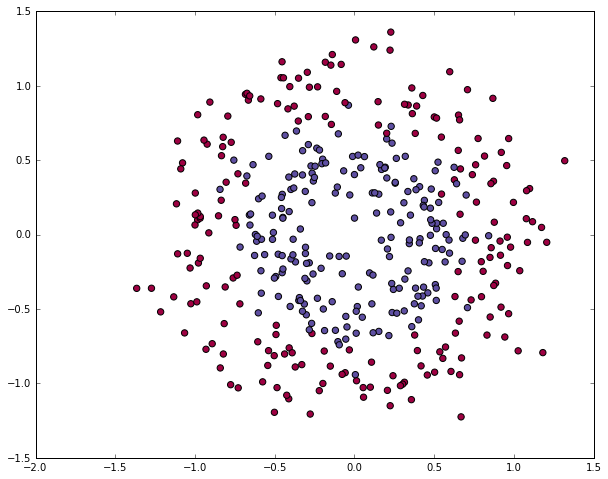

In [2]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_circles(n_samples=400, factor=.5, noise=.17)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

注意到我们特意构建了一个线性不可分的case。也就是说，你无法通过画一条直线将这两部分点区分开来。这也意味着，你无法通过简单的训练一个线性模型，如逻辑回归模型，来区分这两部分点，除非你手动的做一些高阶的特征组合。比如上图中，由于图形中的点大致是用圆形的轮廓来生成的，根据中学数学的知识，我们知道使用x^2+y^2的值可以把这两种点分开。而x^2+y^2就是高阶的特征。

神经网络的优点就是无需构建这种高阶特征。你不需要进行特征工程，神经网络的隐层可以帮你完成这部分操作。

# 逻辑回归

我们直接调用sklearn中的逻辑回归模型包，来实现一个逻辑回归模型。我们是用fit函数来进行训练，然后画出逻辑回归模型的边界。

In [3]:

# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [4]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

/usr/local/lib/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


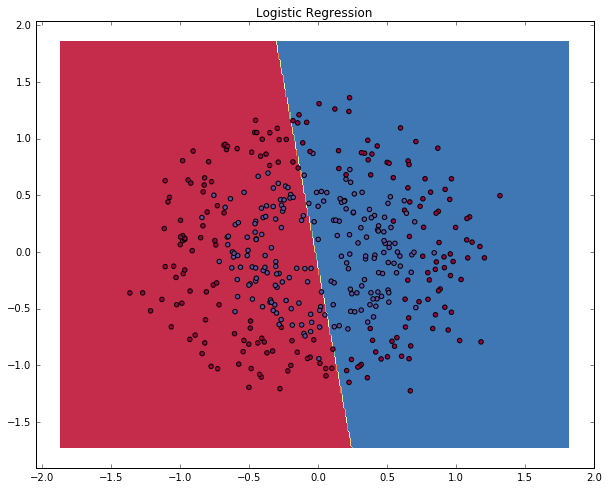

In [5]:

# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

从上图中我们可以看出，不做高阶特征的前提下，逻辑回归模型只能使用一条直线来对点集进行分割。虽然它已经尽力把两种样本分的很均匀，最小化了损失函数，但仍然无法将两种圆圈状的点集准确的区分开。

# 训练神经网络

接下来我们训练一个神经网络。这个网络一共有三层。输入层，输出层和隐含层。由于我们的数据输入只有x和y两个维度，所以我们把输入层节点定为两个。同样的，因为我们的输出只有两种颜色，所以我们把输出节点也定为两个。神经网络的输入是x与y两个坐标，神经网络的输出是两种可能，我们分别标记为0和1。神经网络的结构图如下：

<img src='./nnpic.png' style='width: 90%'/>

现在我们可以选择隐层节点的个数。隐层节点个数越多，神经网络能拟合的函数就越复杂，同时，隐层节点越多，需要的计算量也就越多，同时，模型过拟合的风险也会增加。随后，我们会实验不同节点的个数，来看模型的训练结果会有什么样的不同。

接下来我们选择一下模型隐含层的激活函数。激活函数负责把隐层的输入转化为输出。由于激活函数一般都是非线性的，所以它允许我们拟合非线性的目标函数。常用的激活函数有sigmoid函数，tanh函数，relu函数等。我们这节课使用反正切函数。这些激活函数的一个共同的优秀性质是它们的导数都可以由它们本身的函数值导出。举个例子，tanh(x)的导数为1-tanh(x)^2。这个性质允许我们只计算一遍函数的值，然后通过复用这个结果来进行求导。

在模型的输出层，我们选用softmax函数作为激活函数，这个函数可以很方便的把模型的打分转化为概率值。

## 如何让神经网络做预测

神经网络使用前向传播来进行预测。前向传播其实意味着一系列的矩阵相乘和激活函数的运算。设我们的输入值为x，输出值为y，我们计算y的过程如下：

$$
\begin{aligned}
z_1 & = xW_1 + b_1 \\
a_1 & = \tanh(z_1) \\
z_2 & = a_1W_2 + b_2 \\
a_2 & = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$

z_i是第i层输入项的加权求和（包含偏置项），a_i是激活函数的输出。w_1,b_1,w_2,b_2是我们网络的参数，我们需要从训练数据中学习得到它们。你可以把这些值看成是一些矩阵，这些矩阵负责在神经网络的不同层之间进行数据转化。如果我们有500个节点，那么w_1和w_2就是两个个500乘以2的矩阵。如果我们增加隐层节点数，模型的参数量将有巨大的增长。

## 如何让神经网络学习它的参数

神经网络进行学习的过程，就是寻找w_1,b_1,w_2,b_2这些参数的值的过程。我们寻找最合适的w_1,b_1,w_2,b_2，让我们训练数据中的“偏差”最小。如何定义“偏差”呢，这里引入一个概念叫做损失函数。进行分类的时候，我们经常使用交叉熵作为损失函数。如果我们有N个训练数据，有C个种类，我们的预估值为hat(y)，实际值为y，我们把交叉熵定义为：

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$



虽然这个公式看起来很复杂，但是它只做两件事，第一，挑选出我们预测错的那些case，第二，把这些错误case造成的一些偏差进行求和。所以，如果我们预估值和实际值的差距越大，我们损失函数的loss越大。

定义完loss函数之后，我们的目标仍然是找到w_1,b_1,w_2,b_2的值。我们使用梯度下降法进行求解。这里面需要求偏导数，以及使用反向传播法，公式如下：

$$
\begin{aligned}
& \delta_3 = \hat{y} - y \\
& \delta_2 = (1 - \tanh^2z_1) \circ \delta_3W_2^T \\
& \frac{\partial{L}}{\partial{W_2}} = a_1^T \delta_3  \\
& \frac{\partial{L}}{\partial{b_2}} = \delta_3\\
& \frac{\partial{L}}{\partial{W_1}} = x^T \delta_2\\
& \frac{\partial{L}}{\partial{b_1}} = \delta_2 \\
\end{aligned}
$$


## 实现

我们终于可以写码实现了。首先我们定义一些基本的参数。

In [6]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

然后我们来实现loss函数，如下：

In [7]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

接下来一个函数是用来进行模型预估的，它用到了前向传播：

In [8]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

最后是这个模型的训练过程。它使用反向传播实现了批量梯度下降。

In [9]:

def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

## 训练一个三层的神经网络

传入超参数，运行训练过程

Loss after iteration 0: 0.692953
Loss after iteration 1000: 0.468800
Loss after iteration 2000: 0.249413
Loss after iteration 3000: 0.247736
Loss after iteration 4000: 0.285534
Loss after iteration 5000: 0.484289
Loss after iteration 6000: 0.404016
Loss after iteration 7000: 0.250427
Loss after iteration 8000: 0.246966
Loss after iteration 9000: 0.278551
Loss after iteration 10000: 0.444902
Loss after iteration 11000: 0.453614
Loss after iteration 12000: 0.251943
Loss after iteration 13000: 0.246557
Loss after iteration 14000: 0.271752
Loss after iteration 15000: 0.412426
Loss after iteration 16000: 0.505439
Loss after iteration 17000: 0.253898
Loss after iteration 18000: 0.246353
Loss after iteration 19000: 0.266241


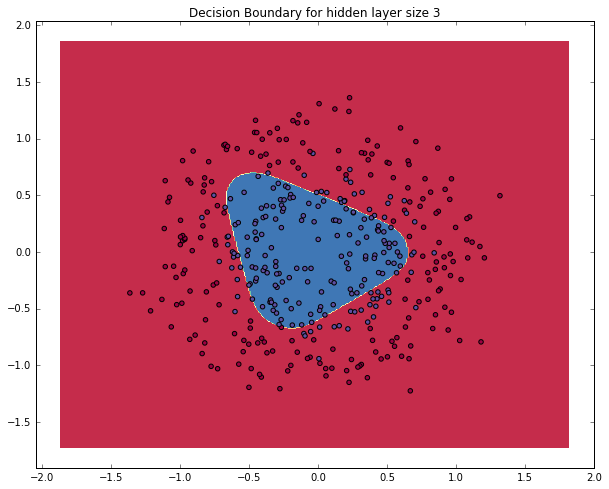

In [10]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

看起来模型学得不错，把内外两个区域区分开来了。三层神经网络比逻辑回归模型效果更优。

## 对隐层节点数进行调试

我们尝试不同的隐层节点数，看结果有什么不同

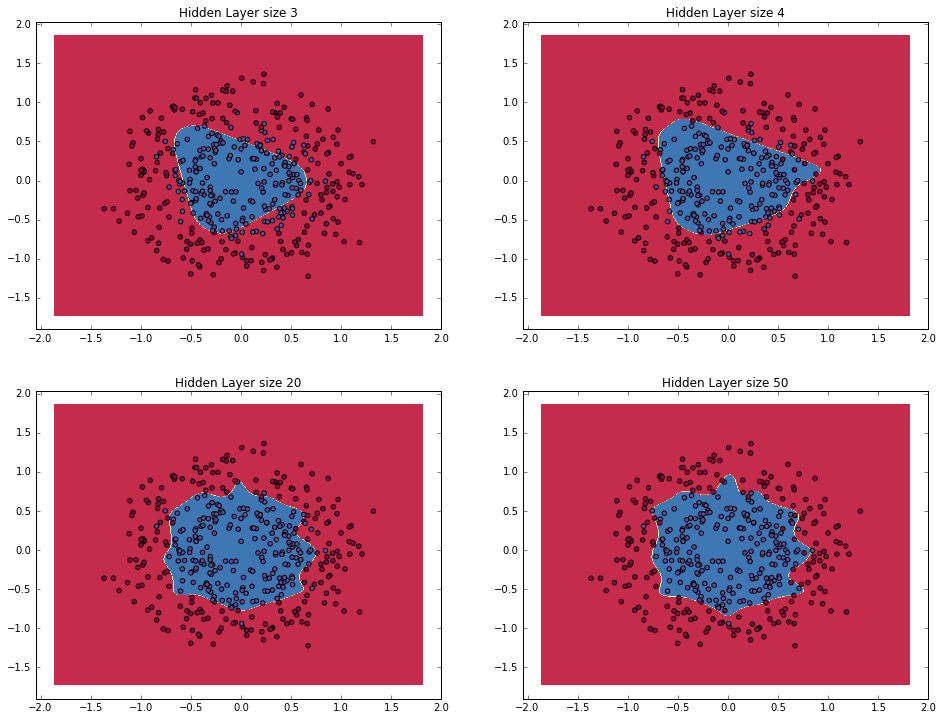

In [11]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [3, 4, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

我们可以发现，较低的隐层节点数很好的把数据区分开来，当隐层节点过多时，边界开始变的凌乱，这就是过拟合的情况正在发生。我们再使用相同的声声方法，生生不同的数据集作为测试集合，对不同的节点数进行测试，来选择最优的节点数。

## 练习

如果进行了以下练习，你的了解将会更加深入：
1. 使用minibatch梯度下降法，代替批量梯度训练法进行训练。
2. 我们使用了固定的学习率，使用一个不断衰减的学习率将会使效果变的更好。
3. 把激活函数从tanh编程其他的试一试。
4. 从新生成训练数据，使用三种类别进行训练。
5. 调整网络结构，使用4层网络代替3层。这样将会修改前向传播和后向传播部分的代码